# Data-Point Reconstruction Attack & Utility Analysis

This notebook simulates a data-point reconstruction attack against a federated k-means algorithm, comparing a **non-private** model to a **differentially private (DP)** one.

The simulation is broken down into these steps:
1.  **Setup:** Import libraries and define all helper functions from the original script.
2.  **Baseline Utility:** Train one full non-private model and one full private model (on all data) to measure their baseline k-means cost and accuracy. This demonstrates the **privacy-utility tradeoff**.
3.  **Load Attack Data:** Load the federated dataset that the attacker will use to select targets.
4.  **Run Attack:** For `NUM_ATTACKS` iterations:
    a. Pick a random client and a random data point from their dataset.
    b. **Train a model *without* that single point** (once for private, once for non-private). This creates the `centers_baseline`.
    c. Simulate the client's update *with* the point (`noisy_update_in`).
    d. Simulate the client's update *without* the point (`noisy_update_out`).
    e. The reconstructed point is `(noisy_update_in - noisy_update_out)`.
    f. Compare the reconstruction to the true point using **L2 Error** and **Cosine Similarity**.
5.  **Final Report:** Display the utility metrics and the attack metrics side-by-side.
6.  **Cleanup:** Remove all generated config and results files.

In [ ]:
# --- 1. Setup & Imports ---

In [16]:
import subprocess
import os
import numpy as np
import yaml
import random
from sklearn.metrics import pairwise_distances
import sys
import math
import pickle 
import argparse # For Namespace object
from pathlib import Path

# --- Add project root to path to ensure imports work ---
# This notebook assumes it is in 'reconstruction_attacks/'
# To run from 'fed-dp-kmeans-main/', change PROJECT_ROOT to "."
PROJECT_ROOT = ".." 
if PROJECT_ROOT not in sys.path:
    # Find the absolute path of the project root relative to this notebook
    # This is a bit more robust for notebooks
    try:
        notebook_dir = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        notebook_dir = os.path.abspath('')
    
    project_root_path = os.path.abspath(os.path.join(notebook_dir, PROJECT_ROOT))
    if project_root_path not in sys.path:
        print(f"Adding {project_root_path} to system path.")
        sys.path.insert(0, project_root_path)

# --- Import from project files ---
try:
    from data import make_data, set_data_args, add_data_arguments
    from utils import kmeans_cost, add_utils_arguments, set_seed, make_results_path
    from utils.argument_parsing import maybe_inject_arguments_from_config
    from pfl.data.sampling import get_user_sampler
    from pfl.data.federated_dataset import FederatedDataset
    from pfl.stats import MappedVectorStatistics
    from privacy.utils import get_mechanism
    from algorithms import add_algorithms_arguments
except ImportError as e:
    print(f"Error: {e}")
    print("Please ensure this notebook is in the 'reconstruction_attacks' directory,")
    print("or change the PROJECT_ROOT variable to point to the 'fed-dp-kmeans-main' directory.")

In [18]:
# --- Main Configuration ---

# Number of attack iterations (target data points).
NUM_ATTACKS = 50

# Global random seed for reproducibility.
SEED = 42

# Base config file to use for DP settings.
BASE_CONFIG_PATH = '../configs/gaussians_data_privacy.yaml'

In [ ]:
def create_recon_configs_datapoint(base_config_path='configs/gaussians_data_privacy.yaml'):
    """
    Creates two config files:
    1.  non_private: All privacy mechanisms AND datapoint_privacy flag are False.
    2.  private: datapoint_privacy is True and all mechanisms are True.
    """
    try:
        with open(base_config_path, 'r') as f: base_config = yaml.safe_load(f)
    except FileNotFoundError:
        print(f"Warning: Base config file '{base_config_path}' not found. Using defaults.")
        base_config = {'dataset': 'GaussianMixtureUniform', 'K': 10, 'dim': 100,'num_train_clients': 100, 'samples_per_client': 1000,'samples_per_mixture_server': 20, 'num_uniform_server': 100,'initialization_algorithm': 'FederatedClusterInitExact', 'clustering_algorithm': 'FederatedLloyds','minimum_server_point_weight': 5, 'fedlloyds_num_iterations': 1,'datapoint_privacy': True, 'outer_product_epsilon': 1, 'weighting_epsilon': 1,'center_init_gaussian_epsilon': 1, 'center_init_epsilon_split': 0.5,'fedlloyds_epsilon': 1, 'fedlloyds_epsilon_split': 0.5,'outer_product_clipping_bound': 11, 'weighting_clipping_bound': 1,'center_init_clipping_bound': 11, 'center_init_laplace_clipping_bound': 1,'fedlloyds_clipping_bound': 11, 'fedlloyds_laplace_clipping_bound': 1,'overall_target_delta': 1e-6, 'fedlloyds_delta': 1e-6, 'send_sums_and_counts': True}
    except Exception as e:
        print(f"Error loading base config '{base_config_path}': {e}. Using defaults.")
        base_config = {'dataset': 'GaussianMixtureUniform', 'K': 10, 'dim': 100, 'num_train_clients': 100, 'samples_per_client': 1000,'samples_per_mixture_server': 20, 'num_uniform_server': 100,'initialization_algorithm': 'FederatedClusterInitExact','clustering_algorithm': 'FederatedLloyds', 'minimum_server_point_weight': 5, 'fedlloyds_num_iterations': 1,'datapoint_privacy': True, 'outer_product_epsilon': 1, 'weighting_epsilon': 1, 'center_init_gaussian_epsilon': 1,'center_init_epsilon_split': 0.5, 'fedlloyds_epsilon': 1, 'fedlloyds_epsilon_split': 0.5,'outer_product_clipping_bound': 11, 'weighting_clipping_bound': 1, 'center_init_clipping_bound': 11,'center_init_laplace_clipping_bound': 1, 'fedlloyds_clipping_bound': 11, 'fedlloyds_laplace_clipping_bound': 1,'overall_target_delta': 1e-6, 'fedlloyds_delta': 1e-6, 'send_sums_and_counts': True}
    
    # Set defaults for required keys
    base_config.setdefault('fedlloyds_num_iterations', 1); base_config.setdefault('fedlloyds_cohort_size', base_config.get('num_train_clients', 100))
    base_config.setdefault('num_train_clients', 100); base_config.setdefault('send_sums_and_counts', True)
    default_delta = base_config.get('overall_target_delta', 1e-6)
    base_config.setdefault('overall_target_delta', default_delta); base_config.setdefault('fedlloyds_delta', default_delta)
    base_config.setdefault('fedlloyds_clipping_bound', 11); base_config.setdefault('fedlloyds_laplace_clipping_bound', 1)

    os.makedirs("reconstruction_attacks/configs", exist_ok=True)
    
    # --- Config 1: Non-Private (All privacy OFF) ---
    config_non_private = base_config.copy()
    config_non_private.update({
        'datapoint_privacy': False,  # <-- As requested
        'outer_product_privacy': False, 
        'point_weighting_privacy': False,
        'center_init_privacy': False, 
        'fedlloyds_privacy': False,
        'fedlloyds_num_iterations': 1
    })
    config_non_private_fname = 'reconstruction_attacks/configs/gaussian_datapoint_non_private.yaml'
    with open(config_non_private_fname, 'w') as f: yaml.dump(config_non_private, f, sort_keys=False)

    # --- Config 2: Private (All privacy ON) ---
    config_private = base_config.copy()
    config_private.update({
        'datapoint_privacy': True, # <-- As requested
        'outer_product_privacy': True, 
        'point_weighting_privacy': True,
        'center_init_privacy': True, 
        'fedlloyds_privacy': True,
        'fedlloyds_num_iterations': 1
    })
    config_private.setdefault('fedlloyds_clipping_bound', 11); config_private.setdefault('fedlloyds_laplace_clipping_bound', 1)
    config_private.setdefault('fedlloyds_delta', config_private.get('overall_target_delta', 1e-6))
    config_private_fname = 'reconstruction_attacks/configs/gaussian_datapoint_private.yaml'
    with open(config_private_fname, 'w') as f: yaml.dump(config_private, f, sort_keys=False)
    
    return config_non_private_fname, config_private_fname

# --- get_target_data ---
def get_target_data(target_client_id_str, all_train_clients):
    user_sampler = get_user_sampler('minimize_reuse', [target_client_id_str])
    target_dataset = FederatedDataset(all_train_clients.make_dataset_fn, user_sampler)
    (user_dataset, _) = next(target_dataset.get_cohort(1))
    if hasattr(user_dataset.raw_data[0], 'numpy'): return user_dataset.raw_data[0].numpy()
    return user_dataset.raw_data[0]

# --- run_training_get_centers (For the attack) ---
def run_training_get_centers(config_file, exclude_client_id_str=None, exclude_datapoint_str=None, seed=None):
    """Runs run.py for the attack (supports exclusions)"""
    cmd = ['python', '../run.py', '--args_config', config_file]
    if exclude_client_id_str: cmd.extend(['--exclude_client_id_str', exclude_client_id_str])
    if exclude_datapoint_str: cmd.extend(['--exclude_datapoint', exclude_datapoint_str])
    if seed is not None: cmd.extend(['--seed', str(seed)])
    print(f"\nRunning command: {' '.join(cmd)}")
    try: subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    except subprocess.CalledProcessError as e: print(f"Error running training: {e}"); return None
    except FileNotFoundError: print("Error: 'python' command not found."); return None
    center_file = 'final_centers.npy'
    if not os.path.exists(center_file): print(f"Error: Center file '{center_file}' not found."); return None
    return center_file

# --- run_main_training_for_utility (For baseline utility) ---
def run_main_training_for_utility(config_file, seed=None):
    """Runs run.py *without* exclusions to generate baseline utility metrics."""
    cmd = ['python', '../run.py', '--args_config', config_file]
    if seed is not None: cmd.extend(['--seed', str(seed)])
    print(f"\nRunning command for baseline utility: {' '.join(cmd)}")
    try: subprocess.run(cmd, check=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    except subprocess.CalledProcessError as e: print(f"Error running baseline utility training: {e}"); return False
    except FileNotFoundError: print("Error: 'python' command not found."); return False
    return True

# --- get_baseline_utility ---
def get_baseline_utility(config_file, seed=None):
    """
    Runs main training once and fetches the cost/accuracy from its summary file.
    """
    # 1. Run main training
    success = run_main_training_for_utility(config_file, seed=seed)
    if not success:
        return np.nan, np.nan

    # 2. Load the config to find the results path
    try:
        config_namespace = load_config_as_namespace(config_file) # Use existing loader
    except Exception as e:
        print(f"Error loading config {config_file} to get results path: {e}")
        return np.nan, np.nan

    # 3. Load the results file
    model_cost, model_accuracy = np.nan, np.nan
    try:
        # Determine correct path based on the config's privacy flag
        privacy_type = 'data_point_level' if config_namespace.datapoint_privacy else 'client_level'
        results_path = make_results_path(privacy_type, config_namespace.dataset)
        summary_file = os.path.join(results_path, 'summary_results.pkl')
        
        if os.path.exists(summary_file):
            with open(summary_file, 'rb') as f:
                results_dict = pickle.load(f)
            
            # Find the final step's results
            final_results_key = 'Clustering' if 'Clustering' in results_dict else 'Initialization'
            if final_results_key in results_dict:
                model_cost = results_dict[final_results_key].get('Train client cost', np.nan)
                model_accuracy = results_dict[final_results_key].get('Train client accuracy', np.nan)
        else:
            print(f"  > Warning: Could not find summary file for utility: {summary_file}")
    except Exception as e:
        print(f"  > Error loading model metrics: {e}")
        
    return model_cost, model_accuracy

# --- load_config_as_namespace (Loads config + defaults) ---
def load_config_as_namespace(config_file):
    # (ensures DP defaults)
    with open(config_file, 'r') as f: config_dict = yaml.safe_load(f)
    config_dict.setdefault('num_train_clients', 100); config_dict.setdefault('send_sums_and_counts', True)
    config_dict.setdefault('center_init_send_sums_and_counts', False); 
    # datapoint_privacy default will be set by the config file itself
    config_dict.setdefault('datapoint_privacy', False) # Default to False if not present
    default_delta = config_dict.get('overall_target_delta', 1e-6); config_dict.setdefault('overall_target_delta', default_delta)
    config_dict.setdefault('fedlloyds_num_iterations', 1); config_dict.setdefault('fedlloyds_cohort_size', config_dict.get('num_train_clients', 100))
    config_dict.setdefault('fedlloyds_epsilon', 1.0); config_dict.setdefault('fedlloyds_epsilon_split', 0.5)
    config_dict.setdefault('fedlloyds_delta', default_delta); config_dict.setdefault('fedlloyds_clipping_bound', 11)
    config_dict.setdefault('fedlloyds_laplace_clipping_bound', 1)
    config_dict.setdefault('outer_product_epsilon', 1.0); config_dict.setdefault('outer_product_delta', default_delta)
    config_dict.setdefault('outer_product_clipping_bound', 11); config_dict.setdefault('weighting_epsilon', 1.0)
    config_dict.setdefault('weighting_clipping_bound', 1); config_dict.setdefault('center_init_gaussian_epsilon', 1.0)
    config_dict.setdefault('center_init_delta', default_delta); config_dict.setdefault('center_init_epsilon_split', 0.5)
    config_dict.setdefault('center_init_clipping_bound', 11); config_dict.setdefault('center_init_laplace_clipping_bound', 1)
    # Add dataset for results path
    config_dict.setdefault('dataset', 'GaussianMixtureUniform')
    return argparse.Namespace(**config_dict)

# --- simulate_client_contribution (Simulates noisy update) ---
def simulate_client_contribution(client_data, global_centers, config_namespace, seed=None):
    K = global_centers.shape[0]; dim = global_centers.shape[1]
    if client_data.shape[0] == 0:
        raw_sums = np.zeros((K, dim), dtype=np.float32); raw_counts = np.zeros(K, dtype=np.float32)
    else:
        if client_data.dtype != global_centers.dtype:
             try: client_data = client_data.astype(global_centers.dtype)
             except ValueError: print("Warning: Data type mismatch, casting to float32."); client_data = client_data.astype(np.float32); global_centers = global_centers.astype(np.float32)
        dist_matrix = pairwise_distances(client_data, global_centers); assignments = np.argmin(dist_matrix, axis=1)
        raw_sums = np.zeros((K, dim), dtype=np.float32); raw_counts = np.zeros(K, dtype=np.float32)
        for k in range(K):
            mask = (assignments == k)
            if np.any(mask): raw_sums[k] = np.sum(client_data[mask], axis=0); raw_counts[k] = np.sum(mask)
    raw_stats_dict = {}
    if config_namespace.send_sums_and_counts: raw_stats_dict['sum_points_per_component'] = raw_sums; raw_stats_dict['num_points_per_component'] = raw_counts
    else: raise NotImplementedError("Only supports 'send_sums_and_counts=True'")
    raw_stats = MappedVectorStatistics(raw_stats_dict)
    mechanism_name = 'fedlloyds' if config_namespace.fedlloyds_privacy else 'no_privacy'
    try:
        if not hasattr(config_namespace, 'fedlloyds_delta'): config_namespace.fedlloyds_delta = config_namespace.overall_target_delta
        mechanism_wrapper = get_mechanism(config_namespace, mechanism_name); underlying_mechanism = mechanism_wrapper.underlying_mechanism
    except Exception as e: print(f"Error getting mechanism '{mechanism_name}': {e}"); raise
    try: sim_seed_clip = seed + 1 if seed is not None else None; clipped_stats, _ = underlying_mechanism.constrain_sensitivity(raw_stats, seed=sim_seed_clip)
    except Exception as e: print(f"Error during constrain_sensitivity: {e}"); clipped_stats = raw_stats
    try: sim_seed_noise = seed + 2 if seed is not None else None; noisy_stats, _ = underlying_mechanism.add_noise(clipped_stats, cohort_size=1, seed=sim_seed_noise)
    except Exception as e: print(f"Error during add_noise: {e}"); noisy_stats = clipped_stats
    final_noisy_sums = np.zeros_like(raw_sums); final_noisy_counts = np.zeros_like(raw_counts)
    if config_namespace.send_sums_and_counts:
        if 'sum_points_per_component' in noisy_stats: final_noisy_sums = noisy_stats['sum_points_per_component']
        else: print("Warning: 'sum_points_per_component' missing.")
        if 'num_points_per_component' in noisy_stats: final_noisy_counts = noisy_stats['num_points_per_component']
        else: print("Warning: 'num_points_per_component' missing.")
    else: raise NotImplementedError("Only supports 'send_sums_and_counts=True'")
    final_noisy_counts = np.maximum(0, final_noisy_counts); return final_noisy_sums, final_noisy_counts

def run_reconstruction_once_single_point(config_file, target_client_id_str, target_sample_idx,
                                         target_datapoint_vector, full_client_data, seed=None):
    """
    Runs one iteration of the single data point reconstruction attack.
    Uses baseline centers trained *without* the target point.
    Returns (squared L2 error, cosine similarity).
    """
    try:
        config_namespace = load_config_as_namespace(config_file)
        if not config_namespace.send_sums_and_counts:
            print(f"Error: Config {config_file} has send_sums_and_counts=False. Skipping."); return np.nan, np.nan
    except Exception as e: print(f"Error loading config {config_file}: {e}"); return np.nan, np.nan

    # 1. Get Global Centers (Trained WITHOUT the target data point)
    print("Running training WITHOUT target POINT to get baseline global centers...")
    exclude_str = f"{target_client_id_str}:{target_sample_idx}"
    train_seed = seed + 50 if seed is not None else None # Seed for training run
    centers_file = run_training_get_centers(config_file, exclude_datapoint_str=exclude_str, seed=train_seed)

    if centers_file is None: 
        print("Failed to get baseline global centers. Skipping."); 
        return np.nan, np.nan

    try: global_centers_baseline = np.load(centers_file) 
    except Exception as e: 
        print(f"Error loading centers {centers_file}: {e}"); error = np.nan
    finally:
        if os.path.exists(centers_file): os.remove(centers_file)
        if 'error' in locals(): return error, np.nan

    # 2. Simulate client contribution WITH the target point (using baseline centers)
    print(f"Simulating contribution WITH target point {target_client_id_str}:{target_sample_idx}...")
    sim_seed_in = seed + 101 if seed is not None else None
    try:
        noisy_sums_in, noisy_counts_in = simulate_client_contribution(
            full_client_data, global_centers_baseline, config_namespace, seed=sim_seed_in # Use baseline centers
        )
    except Exception as e: 
        print(f"Error simulating IN contribution: {e}")
        return np.nan, np.nan

    # 3. Simulate client contribution WITHOUT the target point (using baseline centers)
    print(f"Simulating contribution WITHOUT target point {target_client_id_str}:{target_sample_idx}...")
    client_data_out = np.delete(full_client_data, target_sample_idx, axis=0)
    sim_seed_out = seed + 102 if seed is not None else None
    try:
        noisy_sums_out, noisy_counts_out = simulate_client_contribution(
            client_data_out, global_centers_baseline, config_namespace, seed=sim_seed_out # Use baseline centers
        )
    except Exception as e: 
        print(f"Error simulating OUT contribution: {e}")
        return np.nan, np.nan

    # 4. Calculate the difference (noisy contribution of the single point)
    diff_sums = noisy_sums_in - noisy_sums_out
    diff_counts = noisy_counts_in - noisy_counts_out

    # 5. Reconstruct: Find cluster k* with max count difference, use corresponding sum difference
    if diff_counts.size == 0:
        print("Error: diff_counts is empty."); reconstructed_point = np.full(target_datapoint_vector.shape[1], np.nan)
    else:
        tie_breaker = np.random.randn(*diff_counts.shape) * 1e-9
        probable_cluster_idx = np.argmax(diff_counts + tie_breaker)
        reconstructed_point = diff_sums[probable_cluster_idx]

    # 6. Calculate Squared L2 Error and Cosine Similarity
    error = np.nan
    cosine_sim = np.nan # Initialize
    if np.isnan(reconstructed_point).any():
        print(f"Target {target_client_id_str}:{target_sample_idx}: Reconstruction failed (NaN).")
    else:
        # target_datapoint_vector is (1, D), reconstructed_point is (D,)
        target_vec_1d = target_datapoint_vector.squeeze()
        error = np.sum((target_vec_1d - reconstructed_point)**2) 
        
        # --- ADDED: Cosine Similarity ---
        norm1 = np.linalg.norm(target_vec_1d)
        norm2 = np.linalg.norm(reconstructed_point)
        
        if norm1 > 1e-9 and norm2 > 1e-9:
             cosine_sim = np.dot(target_vec_1d, reconstructed_point) / (norm1 * norm2)
        elif norm1 < 1e-9 and norm2 < 1e-9:
             cosine_sim = 1.0 # Both vectors are zero
        else:
             cosine_sim = 0.0 # One vector is zero
        # --- END ADDED ---

        print(f"Target {target_client_id_str}:{target_sample_idx}: True Norm={norm1:.4f}, Recon Norm={norm2:.4f}, Sq L2 Error={error:.6f}, Cosine Sim={cosine_sim:.6f}")

    return error, cosine_sim

## Step 1: Initialization

First, we set the global seed and create the two `.yaml` config files that `run.py` will use.
-   `gaussian_datapoint_non_private.yaml`: `datapoint_privacy: False` and all sub-mechanisms `False`.
-   `gaussian_datapoint_private.yaml`: `datapoint_privacy: True` and all sub-mechanisms `True`.

In [20]:
if SEED is not None: 
    set_seed(SEED)
    print(f"Set global seed to {SEED}")

print("--- 1. Creating Single-Point Reconstruction Attack config files ---")
config_non_private_file, config_private_file = create_recon_configs_datapoint(BASE_CONFIG_PATH)
print(f"Non-private config: {config_non_private_file}")
print(f"Private config: {config_private_file}")

Set global seed to 42
--- 1. Creating Single-Point Reconstruction Attack config files ---
Non-private config: reconstruction_attacks/configs/gaussian_datapoint_non_private.yaml
Private config: reconstruction_attacks/configs/gaussian_datapoint_private.yaml


## Step 2: Calculate Baseline Model Utility (Privacy-Utility Tradeoff)

This is the step you requested. We run the *full* training process (with no data points excluded) once for the non-private config and once for the private config. We then load the `summary_results.pkl` file generated by `run.py` to get the final k-means cost and accuracy for each model.

In [21]:
print("--- 2. Calculating Baseline Model Utility (this may take a moment) ---")
utility_metrics = {}

print("  Running NON-PRIVATE model...")
cost_np, acc_np = get_baseline_utility(config_non_private_file, seed=SEED)
utility_metrics['non_private'] = {'cost': cost_np, 'accuracy': acc_np}

print("  Running PRIVATE model...")
cost_p, acc_p = get_baseline_utility(config_private_file, seed=SEED)
utility_metrics['private'] = {'cost': cost_p, 'accuracy': acc_p}

--- 2. Calculating Baseline Model Utility (this may take a moment) ---
  Running NON-PRIVATE model...

Running command for baseline utility: python ../run.py --args_config reconstruction_attacks/configs/gaussian_datapoint_non_private.yaml --seed 42
  Running PRIVATE model...

Running command for baseline utility: python ../run.py --args_config reconstruction_attacks/configs/gaussian_datapoint_private.yaml --seed 42


## Analysis: Privacy vs. Utility

Here are the baseline utility metrics. This table shows the *privacy-utility tradeoff*.

In [22]:
print("\n--- BASELINE PRIVACY-UTILITY TRADEOFF ---")
print(f"  NON-PRIVATE: Cost = {cost_np:.6f}, Accuracy = {acc_np:.6f}")
print(f"  PRIVATE:     Cost = {cost_p:.6f}, Accuracy = {acc_p:.6f}")
print("---------------------------------------------")


--- BASELINE PRIVACY-UTILITY TRADEOFF ---
  NON-PRIVATE: Cost = 49.947623, Accuracy = 0.984960
  PRIVATE:     Cost = 49.955225, Accuracy = 0.985000
---------------------------------------------


## Step 3: Load Client Data for Attack

Now, we load the full federated dataset to get the list of clients we can attack.

In [23]:
print("\n--- 3. Loading client list for Attack ---")

# We need to spoof command-line args for the data loader
# This is a bit of a hack required because the project's data loader
# is tied to the command-line parsing system.
original_argv = sys.argv.copy()
try:
    sys.argv = ['run.py', '--args_config', config_non_private_file]
    temp_parser = argparse.ArgumentParser(add_help=False)
    temp_parser = add_data_arguments(temp_parser); temp_parser = add_utils_arguments(temp_parser); temp_parser = add_algorithms_arguments(temp_parser)
    maybe_inject_arguments_from_config()
    data_args, _ = temp_parser.parse_known_args()
    if SEED is not None: data_args.data_seed = SEED
    set_data_args(data_args)
    all_train_clients, _, _, _ = make_data(data_args)
    all_client_ids = [str(i) for i in range(data_args.num_train_clients)]
    print(f"Loaded {len(all_client_ids)} total clients.")
    if not all_client_ids: print("Error: No clients loaded.")
except Exception as e:
    print(f"Fatal Error loading data: {e}")
    print("Data Args:", data_args)
finally:
    # Restore original argv
    sys.argv = original_argv


--- 3. Loading client list for Attack ---
Final Server Dataset Size: 300 samples
Loaded 100 total clients.


## Step 4: Run the Reconstruction Attack

This is the main attack loop. We will iterate `NUM_ATTACKS` times, picking a new random data point each time and attempting to reconstruct it under both private and non-private models.

In [24]:
print(f"\n--- 4. Starting Reconstruction Attack for {NUM_ATTACKS} points ---")

results = {
    'non_private': {'errors': [], 'cosine_sims': []},
    'private': {'errors': [], 'cosine_sims': []}
}
config_files = {'non_private': config_non_private_file, 'private': config_private_file}
rng = np.random.default_rng(SEED)

attacks_run = 0; client_sample_attempts = 0; max_client_attempts = NUM_ATTACKS * 5

if 'all_client_ids' in locals() and all_client_ids:
    while attacks_run < NUM_ATTACKS and client_sample_attempts < max_client_attempts:
        client_sample_attempts += 1
        target_client_id = rng.choice(all_client_ids)
        print(f"\n--- Trying Client {target_client_id} (Attempt {client_sample_attempts}) ---")
        try: full_client_data = get_target_data(target_client_id, all_train_clients)
        except StopIteration: print(f"Error sampling client {target_client_id}."); continue
        except Exception as e: print(f"Error loading data for {target_client_id}: {e}"); continue
        if full_client_data.shape[0] == 0: print(f"Client {target_client_id} has no data."); continue

        target_sample_idx = rng.integers(0, full_client_data.shape[0])
        target_datapoint_vector = full_client_data[target_sample_idx:target_sample_idx+1]
        print(f"Target point: Client {target_client_id}, Index {target_sample_idx} (of {full_client_data.shape[0]})")

        attack_successful_this_iter = False; current_iter_results = {}
        for mode in ['non_private', 'private']:
            print(f"--- Running {mode.upper()} scenario ---")
            config_file = config_files[mode]
            iter_seed = (SEED + attacks_run*10 + (0 if mode == 'non_private' else 1)) if SEED is not None else None
            try:
                #Call the reconstruction function
                error, cos_sim = run_reconstruction_once_single_point(
                    config_file, target_client_id, target_sample_idx,
                    target_datapoint_vector, full_client_data, seed=iter_seed
                )
                if not np.isnan(error):
                    current_iter_results[mode] = (error, cos_sim) # Store both
                    attack_successful_this_iter = True
                else: print(f"Reconstruction failed in {mode} mode (NaN error).")
            except Exception as e: print(f"Attack failed unexpectedly for {mode}: {e}"); import traceback; traceback.print_exc()

        # Update results collection
        if 'non_private' in current_iter_results and 'private' in current_iter_results:
             err_np, sim_np = current_iter_results['non_private']
             results['non_private']['errors'].append(err_np)
             results['non_private']['cosine_sims'].append(sim_np)
             
             err_p, sim_p = current_iter_results['private']
             results['private']['errors'].append(err_p)
             results['private']['cosine_sims'].append(sim_p)
             
             attacks_run += 1
        elif attack_successful_this_iter: print("Attack completed for only one mode, results discarded.")

    if attacks_run < NUM_ATTACKS: print(f"\nWarning: Only completed {attacks_run}/{NUM_ATTACKS} iterations.")
else:
    print("\n--- SKIPPING ATTACK: Client data was not loaded successfully ---")


--- 4. Starting Reconstruction Attack for 50 points ---

--- Trying Client 8 (Attempt 1) ---
Target point: Client 8, Index 773 (of 1000)
--- Running NON_PRIVATE scenario ---
Running training WITHOUT target POINT to get baseline global centers...

Running command: python ../run.py --args_config reconstruction_attacks/configs/gaussian_datapoint_non_private.yaml --exclude_datapoint 8:773 --seed 92
Simulating contribution WITH target point 8:773...
Simulating contribution WITHOUT target point 8:773...
Target 8:773: True Norm=8.2829, Recon Norm=8.2829, Sq L2 Error=0.000000, Cosine Sim=1.000000
--- Running PRIVATE scenario ---
Running training WITHOUT target POINT to get baseline global centers...

Running command: python ../run.py --args_config reconstruction_attacks/configs/gaussian_datapoint_private.yaml --exclude_datapoint 8:773 --seed 93
Simulating contribution WITH target point 8:773...
Simulating contribution WITHOUT target point 8:773...
Target 8:773: True Norm=8.2829, Recon Norm=13

## Step 5: Final Results & Analysis

Here is the final report. 

We can see the **Model Utility** (Cost/Accuracy) at the top, followed by the **Reconstruction Attack Metrics** (L2 Error/Cosine Similarity).

In [25]:
print("\n--- FINAL SINGLE-POINT RECONSTRUCTION RESULTS ---")

print("\n--- Model Utility (Privacy-Utility Tradeoff) ---")
print(f"  NON-PRIVATE: Cost = {utility_metrics['non_private']['cost']:.6f}, Accuracy = {utility_metrics['non_private']['accuracy']:.6f}")
print(f"  PRIVATE:     Cost = {utility_metrics['private']['cost']:.6f}, Accuracy = {utility_metrics['private']['accuracy']:.6f}")

print("\n--- Reconstruction Attack Metrics ---")
for mode in ['non_private', 'private']:
    res = results[mode]
    count = len(res['errors'])
    if count > 0:
        print(f"\n{mode.upper()} Model Results ({count} points):")
        
        # Reconstruction Error
        errors = res['errors']
        avg_error=np.nanmean(errors); std_error=np.nanstd(errors); median_error=np.nanmedian(errors)
        print(f"  Reconstruction Sq L2 Error:")
        print(f"    Avg: {avg_error:.6f}, StdDev: {std_error:.6f}, Median: {median_error:.6f}")

        # Cosine Similarity
        sims = res['cosine_sims']
        avg_sim=np.nanmean(sims); std_sim=np.nanstd(sims); median_sim=np.nanmedian(sims)
        print(f"  Reconstruction Cosine Similarity:")
        print(f"    Avg: {avg_sim:.6f}, StdDev: {std_sim:.6f}, Median: {median_sim:.6f}")
    else: 
        print(f"\n{mode.upper()} Model: No successful attacks.")


--- FINAL SINGLE-POINT RECONSTRUCTION RESULTS ---

--- Model Utility (Privacy-Utility Tradeoff) ---
  NON-PRIVATE: Cost = 49.947623, Accuracy = 0.984960
  PRIVATE:     Cost = 49.955225, Accuracy = 0.985000

--- Reconstruction Attack Metrics ---

NON_PRIVATE Model Results (50 points):
  Reconstruction Sq L2 Error:
    Avg: 0.000000, StdDev: 0.000000, Median: 0.000000
  Reconstruction Cosine Similarity:
    Avg: 1.000000, StdDev: 0.000000, Median: 1.000000

PRIVATE Model Results (50 points):
  Reconstruction Sq L2 Error:
    Avg: 1617845.796825, StdDev: 231765.931315, Median: 1583753.918921
  Reconstruction Cosine Similarity:
    Avg: 0.010905, StdDev: 0.100862, Median: 0.001650


## Step 6: Cleanup

Finally, we remove all the temporary config files, model center files (`.npy`), and results files (`.pkl`) created during the run.

In [28]:
print("\n--- 6. Cleaning up generated files... ---")
try:
    if os.path.exists(config_non_private_file): 
        os.remove(config_non_private_file)
        print(f"Removed {config_non_private_file}")
    if os.path.exists(config_private_file): 
        os.remove(config_private_file)
        print(f"Removed {config_private_file}")
    if os.path.exists('final_centers.npy'): 
        os.remove('final_centers.npy')
        print("Removed final_centers.npy")
        
    # Clean up utility results files
    for cfg_file in [config_non_private_file, config_private_file]:
        try:
            ns = load_config_as_namespace(cfg_file) # Config file might be deleted, load from memory
            ptype = 'data_point_level' if ns.datapoint_privacy else 'client_level'
            rpath = make_results_path(ptype, ns.dataset)
            sfile = os.path.join(rpath, 'summary_results.pkl')
            if os.path.exists(sfile): 
                os.remove(sfile)
                print(f"Removed {sfile}")
        except Exception as e:
            print(f"Note: Could not clean up summary file for {cfg_file}. It may already be gone. {e}")
            
    print("Cleanup complete.")
except OSError as e: 
    print(f"Error during cleanup: {e}")


--- 6. Cleaning up generated files... ---
Removed reconstruction_attacks/configs/gaussian_datapoint_non_private.yaml
Removed reconstruction_attacks/configs/gaussian_datapoint_private.yaml
Note: Could not clean up summary file for reconstruction_attacks/configs/gaussian_datapoint_non_private.yaml. It may already be gone. [Errno 2] No such file or directory: 'reconstruction_attacks/configs/gaussian_datapoint_non_private.yaml'
Note: Could not clean up summary file for reconstruction_attacks/configs/gaussian_datapoint_private.yaml. It may already be gone. [Errno 2] No such file or directory: 'reconstruction_attacks/configs/gaussian_datapoint_private.yaml'
Cleanup complete.


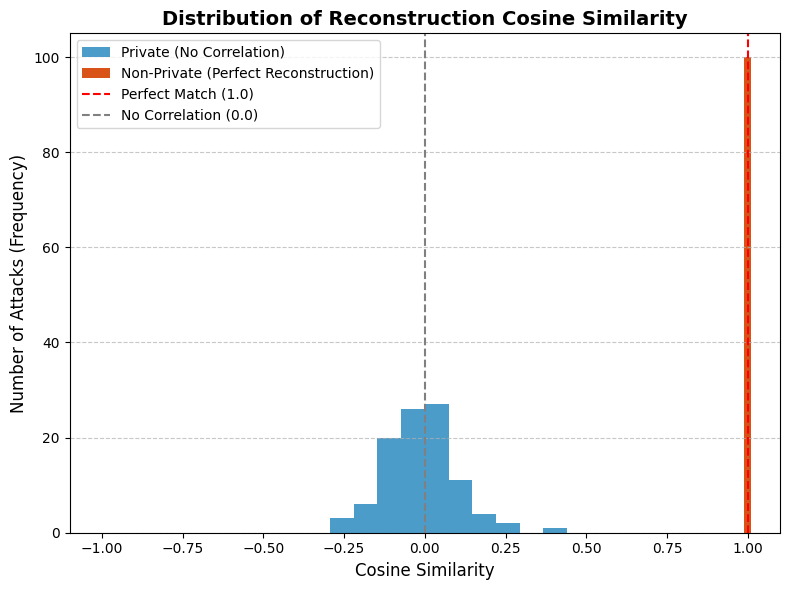

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# --- Example Data (You should replace this with your actual 'results' dictionary) ---
# Assuming 100 successful attacks for non-private and 100 failed for private
non_private_count = 50
private_count = 50
# ----------------------------------------------------------------------------------

models = ['Non-Private', 'Private']
colors = ['#D95319', '#0072B2'] # (Red/Orange, Blue)

# --- Create Single Plot ---
plt.figure(figsize=(8, 6)) # Adjusted figure size for a single plot

# ======================================================================
# Plot: Cosine Similarity Distribution (Revised) 📐
# ======================================================================

# Plot private (clustered around 0.0) with more bins for better detail
plt.hist(results['private']['cosine_sims'], bins=30, range=(-1.1, 1.1), alpha=0.7, color=colors[1], label='Private (No Correlation)')

# Plot non-private (all at 1.0) using a very narrow custom bin to create a sharp bar
non_private_bins = [0.99, 1.01] # Creates a single bin centered at 1.0
plt.hist(results['non_private']['cosine_sims'], bins=non_private_bins, alpha=1.0, color=colors[0], label='Non-Private (Perfect Reconstruction)')

plt.title('Distribution of Reconstruction Cosine Similarity', fontsize=14, fontweight='bold')
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Number of Attacks (Frequency)', fontsize=12)
plt.xlim(-1.1, 1.1)

# Add reference lines for clarity
plt.axvline(1.0, color='red', linestyle='--', label='Perfect Match (1.0)')
plt.axvline(0.0, color='grey', linestyle='--', label='No Correlation (0.0)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()

# --- Save the Figure ---
plt.savefig('cosine_similarity_attack_results.png', dpi=300) # Saves the plot with high resolution
plt.show()

In [36]:
import re
import numpy as np

def reconstruct_results_from_log(log_file_path):
    """
    Reads a reconstruction attack log file, extracts the Sq L2 Error and Cosine Sim
    for non-private and private scenarios, and returns them in the required dictionary format.
    
    Args:
        log_file_path (str): The path to the log file (e.g., 'res.txt').

    Returns:
        dict: A dictionary in the format {'non_private': {'errors': np.array, 'cosine_sims': np.array}, ...}
    """
    results = {
        'non_private': {'errors': [], 'cosine_sims': []},
        'private': {'errors': [], 'cosine_sims': []}
    }
    
    try:
        with open(log_file_path, 'r') as f:
            log_content = f.read()
    except FileNotFoundError:
        print(f"Error: Log file not found at {log_file_path}")
        return None

    # This pattern captures the scenario name (NON_PRIVATE or PRIVATE)
    # and the line containing the metrics (Sq L2 Error and Cosine Sim)
    pattern = re.compile(
        r'--- Running (NON_PRIVATE|PRIVATE) scenario ---\s*.*?'  # Scenario header
        r'Target.*?Sq L2 Error=(\d+\.\d+), Cosine Sim=([-\d]+\.\d+)', # Metrics line
        re.DOTALL
    )

    matches = pattern.findall(log_content)
    
    if not matches:
        print("Warning: No attack results found matching the expected pattern.")
        return None

    for scenario, error_str, sim_str in matches:
        # Convert the captured string values to float
        error_val = float(error_str)
        sim_val = float(sim_str)
        
        # Determine which list to append to
        if scenario == 'NON_PRIVATE':
            results['non_private']['errors'].append(error_val)
            results['non_private']['cosine_sims'].append(sim_val)
        elif scenario == 'PRIVATE':
            results['private']['errors'].append(error_val)
            results['private']['cosine_sims'].append(sim_val)

    # Convert lists to numpy arrays for plotting
    for mode in results:
        results[mode]['errors'] = np.array(results[mode]['errors'])
        results[mode]['cosine_sims'] = np.array(results[mode]['cosine_sims'])

    print(f"Successfully extracted {len(results['non_private']['errors'])} non_private and {len(results['private']['errors'])} private attack results.")
    return results

# --- Example Usage ---
# Assuming your log file is named 'res.txt' in the same directory
log_file = '/home/urvi/maml_project/res.txt'
results_for_plotting = reconstruct_results_from_log(log_file)

# You can now use 'results_for_plotting' directly in the plotting script
if results_for_plotting:
    print("\nReconstructed Results Summary (First 3 points):")
    print("Non-Private Cosine Sims:", results_for_plotting['non_private']['cosine_sims'][:3])
    print("Private Cosine Sims:", results_for_plotting['private']['cosine_sims'][:3])
    
    # --- PLOTTING SCRIPT ---
    # (You can append the full plotting code here or run it separately)
    # The plotting code from the previous turn is ready to accept this 'results_for_plotting' dictionary.

Successfully extracted 50 non_private and 50 private attack results.

Reconstructed Results Summary (First 3 points):
Non-Private Cosine Sims: [1. 1. 1.]
Private Cosine Sims: [-0.134505 -0.033352  0.003969]


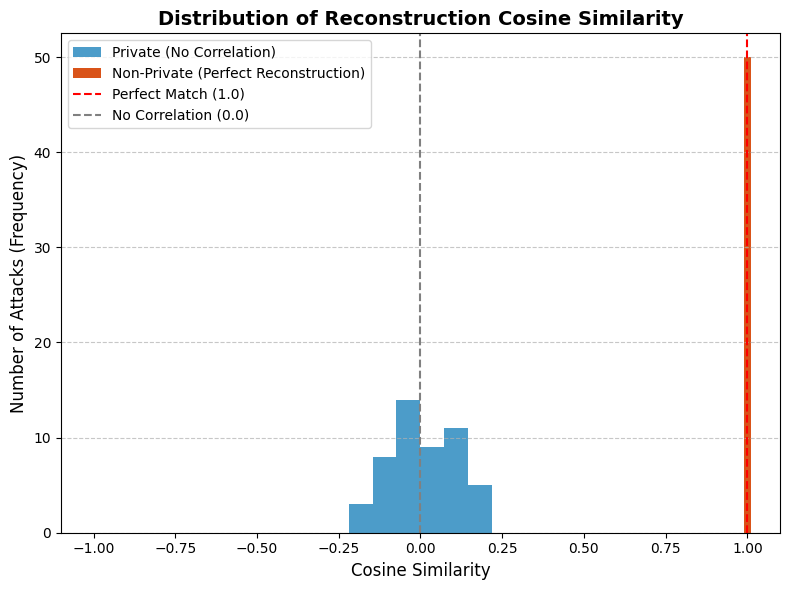

In [39]:
import matplotlib.pyplot as plt
import numpy as np
import re
from io import StringIO

# --- 1. Log Parsing Function ---
def reconstruct_results_from_log(log_content):
    """
    Parses the log content string to extract error and cosine similarity metrics.
    
    Args:
        log_content (str): The entire content of the log file (res.txt).

    Returns:
        dict: A dictionary with 'non_private' and 'private' results.
    """
    results = {
        'non_private': {'errors': [], 'cosine_sims': []},
        'private': {'errors': [], 'cosine_sims': []}
    }
    
    # Pattern to capture scenario and metrics (Sq L2 Error and Cosine Sim)
    pattern = re.compile(
        r'--- Running (NON_PRIVATE|PRIVATE) scenario ---\s*.*?'  # Scenario header
        r'Target.*?Sq L2 Error=(\d+\.\d+), Cosine Sim=([-\d]+\.\d+)', # Metrics line
        re.DOTALL
    )

    matches = pattern.findall(log_content)

    for scenario, error_str, sim_str in matches:
        error_val = float(error_str)
        sim_val = float(sim_str)
        
        mode = scenario.lower()
        results[mode]['errors'].append(error_val)
        results[mode]['cosine_sims'].append(sim_val)

    # Convert lists to numpy arrays
    for mode in results:
        results[mode]['errors'] = np.array(results[mode]['errors'])
        results[mode]['cosine_sims'] = np.array(results[mode]['cosine_sims'])
        
    return results

# --- 2. Load and Process Log Data ---
# ⚠️ IMPORTANT: Ensure 'res.txt' is accessible (e.g., in the same directory)
log_file_path = '/home/urvi/maml_project/res.txt'

try:
    with open(log_file_path, 'r') as f:
        log_content = f.read()
    
    results = reconstruct_results_from_log(log_content)
    
    if not results['non_private']['cosine_sims'].size or not results['private']['cosine_sims'].size:
        print("Error: Could not extract data. Check log format.")
        # Fallback/exit if extraction fails
        raise ValueError("Data extraction failed.")

except FileNotFoundError:
    print(f"Error: Log file '{log_file_path}' not found. Please check the path.")
    # Exit script execution gracefully if file isn't found
    raise

# --- 3. Plotting Code ---
colors = ['#D95319', '#0072B2'] # (Red/Orange, Blue)

plt.figure(figsize=(8, 6)) # Single plot size

# ======================================================================
# Plot: Cosine Similarity Distribution (Using extracted 'results') 📐
# ======================================================================

# Plot private (clustered around 0.0) with more bins for better detail
plt.hist(
    results['private']['cosine_sims'], 
    bins=30, 
    range=(-1.1, 1.1), 
    alpha=0.7, 
    color=colors[1], 
    label='Private (No Correlation)'
)

# Plot non-private (all at 1.0) using a very narrow custom bin to create a sharp bar
non_private_bins = [0.99, 1.01] # Creates a single bin centered at 1.0
plt.hist(
    results['non_private']['cosine_sims'], 
    bins=non_private_bins, 
    alpha=1.0, 
    color=colors[0], 
    label='Non-Private (Perfect Reconstruction)'
)

plt.title('Distribution of Reconstruction Cosine Similarity', fontsize=14, fontweight='bold')
plt.xlabel('Cosine Similarity', fontsize=12)
plt.ylabel('Number of Attacks (Frequency)', fontsize=12)
plt.xlim(-1.1, 1.1)

# Add reference lines for clarity
plt.axvline(1.0, color='red', linestyle='--', label='Perfect Match (1.0)')
plt.axvline(0.0, color='grey', linestyle='--', label='No Correlation (0.0)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()

# --- Save the Figure ---
plt.savefig('reconstruction_attack_results_datapoint.png', dpi=300) 
plt.show()